<a href="https://colab.research.google.com/github/farazzashraf/LGMVIP--DataScience/blob/main/Stock_Market_Prediction_And_Forecasting_Using_Stacked_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [14]:
np.random.seed(42)
tf.random.set_seed(42)
data = pd.read_csv('stockprice.csv')
data.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,28-09-2018,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,27-09-2018,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,26-09-2018,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,25-09-2018,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,24-09-2018,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [15]:
# Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.sort_index(ascending=True, axis=0, inplace=True)

<ipython-input-15-1a741ff606f9>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Date'] = pd.to_datetime(data['Date'])


In [16]:
# SPlitting the data into training and testing sets
train_data = data[:int(0.8*len(data))]
test_data = data[int(0.8*len(data)):]

In [17]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data['Close'].values.reshape(-1, 1))

In [18]:
# Generating sequences for training
def generate_sequences(data, sequence_length):
  x = []
  y = []
  for i in range(len(data) - sequence_length):
    x.append(data[i:i + sequence_length, 0])
    y.append(data[i + sequence_length, 0])
  return np.array(x), np.array(y)

sequence_length = 60
x_train, y_train = generate_sequences(scaled_train_data, sequence_length)

In [19]:
# Building stacked LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

In [20]:
# Compilling and training the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
49/49 [==============================] - 7s 73ms/step - loss: 0.0118
Epoch 2/10
49/49 [==============================] - 4s 86ms/step - loss: 0.0042
Epoch 3/10
49/49 [==============================] - 5s 94ms/step - loss: 0.0040
Epoch 4/10
49/49 [==============================] - 7s 151ms/step - loss: 0.0039
Epoch 5/10
49/49 [==============================] - 7s 133ms/step - loss: 0.0039
Epoch 6/10
49/49 [==============================] - 6s 118ms/step - loss: 0.0038
Epoch 7/10
49/49 [==============================] - 4s 71ms/step - loss: 0.0037
Epoch 8/10
49/49 [==============================] - 3s 66ms/step - loss: 0.0034
Epoch 9/10
49/49 [==============================] - 3s 69ms/step - loss: 0.0032
Epoch 10/10
49/49 [==============================] - 5s 106ms/step - loss: 0.0031


In [24]:
# Making prediction and visualizing the results
last_sequence = scaled_train_data[-sequence_length:].reshape(1, sequence_length, 1)
forecast = []
num_forecast_values = len(test_data)
for _ in range(num_forecast_values):
  next_pred = model.predict(last_sequence)
  forecast.append(next_pred[0][0])
  last_sequence = np.append(last_sequence[:, 1:, :], next_pred.reshape(1,1,1), axis=1)

forecast = np.array(forecast).reshape(-1, 1)
forecast = scaler.inverse_transform(forecast)

forecast_dates = pd.date_range(start=test_data.index[-1], periods=num_forecast_values + 1, closed='right')

1/1 [==============================] - 0s 30ms/step


<ipython-input-24-caab21bbfb0f>:13: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  forecast_dates = pd.date_range(start=test_data.index[-1], periods=num_forecast_values + 1, closed='right')


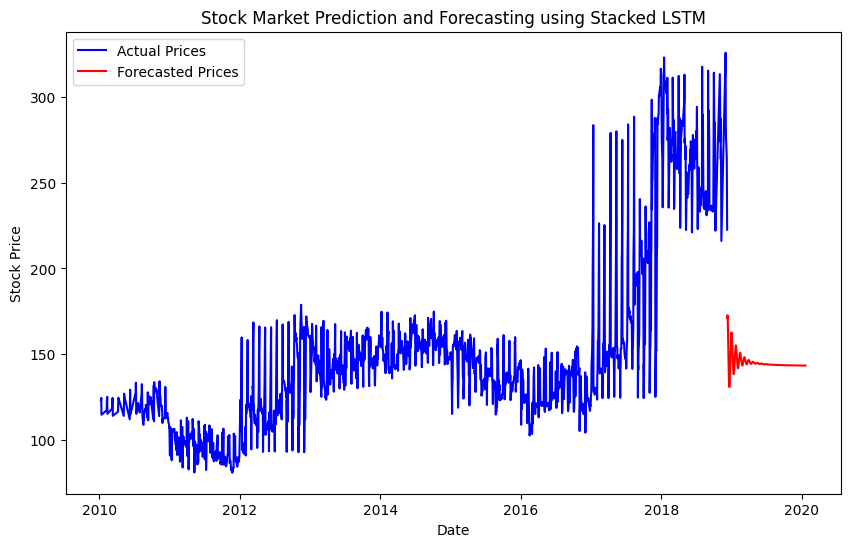

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label="Actual Prices", color='blue')
plt.plot(forecast_dates, forecast, label='Forecasted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Market Prediction and Forecasting using Stacked LSTM')
plt.legend()
plt.show()